In [19]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from tabulate import tabulate
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from stargazer.stargazer import Stargazer
import scipy.stats as stats
import seaborn as sns
import os

In [20]:
# File Paths
absolute_path = "C:\\Users\\tykun\\\OneDrive\\Documents\\SchoolDocs\VSCodeProjects\\connectedData\\board_analysis\\"
altered_dataframes = "altered_dataframes\\"
gpt_dataframes = "gpt_dataframes\\"
graphs = "graphs\\"
scripts =  "scripts\\"
board_dataframes = "board_dataframes\\"
temporary = "temporary_data\\"
final_scripts = "final_scripts\\"
normalized_dataframes = "normalized_dataframes\\"
college_matching = "college_matching\\"
regression = "regression\\"
normalized_dataframes = "normalized_dataframes\\"
normalized_regression_boards = "normalized_regression_boards\\"
network = "network\\"
network_boards = "network_boards\\"

altered_dataframe_path = f"{absolute_path}{altered_dataframes}"
gpt_dataframe_path = f"{absolute_path}{gpt_dataframes}" 
graph_path = f"{absolute_path}{graphs}"
script_path = f"{absolute_path}{scripts}"
boards_path = f"{absolute_path}{board_dataframes}"
temporary_data_path = f"{absolute_path}{temporary}"

years = ["1999", "2000", "2005", "2007", "2008", "2009", "2010", "2011", "2013", "2018"]


In [21]:
def remove_non_samples(df):
    df = df[df['PrimarySample'] == True]
    return df

In [22]:
university_stats_path = os.path.join(absolute_path, final_scripts, regression, "regression_stats\\regression_university_board_statistics.csv")
school_stats_path = os.path.join(absolute_path, final_scripts, regression, "regression_stats\\university_statistics_for_regression_new.csv")

university_board_statistics_df = pd.read_csv(university_stats_path)
school_statistics_df = pd.read_csv(school_stats_path)

In [23]:
print(university_board_statistics_df.columns)

Index(['Year', 'Institution', 'AffiliationId', 'female_president',
       'PrimarySample', 'total_members', 'total_ethnicity', 'board_turnover',
       'carnegie_id', 'state', 'control', 'StateSystem', 'region',
       'num_billionaires', 'student.women', 'faculty.women',
       'faculty.race_ethnicity.white', 'student.size',
       'cost.tuition.out_of_state', 'school.faculty_salary', 'RD_expenditure',
       'female_proportion', 'poc_proportion', 'billionaire_proportion',
       'eigenvector', 'betweenness', 'degree', 'strength', 'clustering',
       'Rank'],
      dtype='object')


In [24]:
aff_ids_with_na = (
    university_board_statistics_df
    .groupby("AffiliationId")
    .filter(lambda group: group.isna().any().any())["AffiliationId"]
    .unique()
)
print(aff_ids_with_na)

# Drop all rows with these AffiliationIds
clean_df = university_board_statistics_df[
    ~university_board_statistics_df["AffiliationId"].isin(aff_ids_with_na)
].copy()


university_board_statistics_df = clean_df


[]


In [25]:

dependent_var = "female_president"
year_var = "Year"


independent_vars = [
    "student.women", 
    "student.size", 
    "female_proportion",
    "billionaire_proportion",
    "total_members",
    "betweenness",
    "degree",
    "faculty.race_ethnicity.white",
    "poc_proportion",
    "board_turnover",
    "control",
    "faculty.women",
    "strength",
    "cost.tuition.out_of_state",
    "school.faculty_salary",
    "RD_expenditure",
    "clustering",
    # "Rank"
]


cols_to_check = [dependent_var] + independent_vars + [year_var, "control"]
regression_data = university_board_statistics_df.dropna(subset=cols_to_check).copy()

regression_data[dependent_var] = regression_data[dependent_var].astype(int)

#one-hot encode Year and control.
# drop_first=True avoids the dummy variable trap.
regression_data = pd.get_dummies(
    regression_data,
    columns=[year_var, "control"],
    drop_first=True
)

#identify the dummy columns for Year and control.
year_dummies = [col for col in regression_data.columns if col.startswith(f"{year_var}_")]
control_dummies = [col for col in regression_data.columns if col.startswith("control_")]

#remove the original "control" from independent_vars and add our new dummy variables.
predictor_vars = [var for var in independent_vars if var not in ["control"]] + year_dummies + control_dummies

X = regression_data[predictor_vars]
y = regression_data[dependent_var]

#ensure all predictor columns are numeric.
X = X.apply(pd.to_numeric, errors='raise')

#normalize continuous predictors.
#exclude dummy variables (for year and control) from scaling.
continuous_vars = [
    "student.women", 
    "student.size", 
    "female_proportion",
    "billionaire_proportion",
    "total_members",
    "betweenness",
    "degree",
    "faculty.race_ethnicity.white",
    "poc_proportion",
    "board_turnover",
    "faculty.women",
    "strength",
    "cost.tuition.out_of_state",
    "school.faculty_salary",
    "RD_expenditure",
    "clustering", 
    # "Rank"
]

scaler = StandardScaler()
vars_to_scale = [var for var in continuous_vars if var in X.columns]
X_scaled = X.copy()
X_scaled[vars_to_scale] = scaler.fit_transform(X_scaled[vars_to_scale])

# Ensure the scaled data is numeric.
X_scaled = X_scaled.apply(pd.to_numeric, errors='raise')

# Add an intercept.
X_scaled = sm.add_constant(X_scaled)
# Force all columns to float to avoid object dtype errors.
X_scaled = X_scaled.astype(float)

# Fit the logistic regression model.
logit_model = sm.Logit(y, X_scaled)
result = logit_model.fit()


# Create a DataFrame with odds ratios and p-values.
odds_ratios = pd.DataFrame({
    "Variable": X_scaled.columns,
    "Coefficient": result.params,
    "Odds Ratio": np.exp(result.params),
    "P-Value": result.pvalues
})

print(result.summary())
print("\nOdds Ratios and P-Values:")
print(tabulate(odds_ratios, headers="keys", tablefmt="grid"))

# Calculate Variance Inflation Factors (VIF).
if 'const' in X_scaled.columns:
    X_check = X_scaled.drop('const', axis=1)
else:
    X_check = X_scaled.copy()

vif_data = pd.DataFrame({
    "Variable": X_check.columns,
    "VIF": [variance_inflation_factor(X_check.values, i) for i in range(X_check.shape[1])]
})
print("\nVariance Inflation Factors (VIF):")
print(tabulate(vif_data, headers="keys", tablefmt="grid"))


Optimization terminated successfully.
         Current function value: 0.254199
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:       female_president   No. Observations:                 1790
Model:                          Logit   Df Residuals:                     1763
Method:                           MLE   Df Model:                           26
Date:                Wed, 19 Feb 2025   Pseudo R-squ.:                  0.1089
Time:                        13:18:32   Log-Likelihood:                -455.02
converged:                       True   LL-Null:                       -510.63
Covariance Type:            nonrobust   LLR p-value:                 1.624e-12
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -2.6074      0.487     -5.355      0.000

In [26]:
# Define the dependent variable and the year variable.
dependent_var = "female_president"
year_var = "Year"

# Updated full list of independent variables (removed "region").
independent_vars = [
    "student.women", 
    "student.size", 
    "female_proportion",
    "billionaire_proportion",
    "total_members",
    "betweenness",
    "degree",
    "faculty.race_ethnicity.white",
    "poc_proportion",
    "board_turnover",
    "control",
    "faculty.women",
    "strength",
    "cost.tuition.out_of_state",
    "school.faculty_salary",
    "RD_expenditure",
    "clustering"
]

# Drop rows missing any of the variables used in any model.
cols_to_check = [dependent_var, year_var] + independent_vars
regression_data = university_board_statistics_df.dropna(subset=cols_to_check).copy()

# Ensure the dependent variable is binary.
regression_data[dependent_var] = regression_data[dependent_var].astype(int)

# One-hot encode Year and control (region is no longer used).
# (Using drop_first=True to avoid the dummy variable trap.)
regression_data = pd.get_dummies(
    regression_data,
    columns=[year_var, "control"],
    drop_first=True
)

# Identify dummy columns.
year_dummies = [col for col in regression_data.columns if col.startswith(f"{year_var}_")]
control_dummies = [col for col in regression_data.columns if col.startswith("control_")]

# Define continuous variables to be scaled.
continuous_vars = [
    "student.women", 
    "student.size", 
    "female_proportion",
    "billionaire_proportion",
    "total_members",
    "betweenness",
    "degree",
    "faculty.race_ethnicity.white",
    "poc_proportion",
    "board_turnover",
    "faculty.women",
    "strength",
    "cost.tuition.out_of_state",
    "school.faculty_salary",
    "RD_expenditure",
    "clustering"
]

# Standardize continuous variables.
scaler = StandardScaler()
vars_to_scale = [var for var in continuous_vars if var in regression_data.columns]
regression_data[vars_to_scale] = scaler.fit_transform(regression_data[vars_to_scale])


model1_vars = ["student.size", "student.women", "cost.tuition.out_of_state"]

model2_vars = model1_vars + [
    "faculty.women", 
    "faculty.race_ethnicity.white", 
    "school.faculty_salary", 
    "RD_expenditure"
]

model3_vars = model2_vars + ["female_proportion", "board_turnover", "total_members", "poc_proportion", "billionaire_proportion"]

model4_vars = model3_vars + ["betweenness", "degree", "strength", "clustering"]

# Modified function to add only control and year dummies.
def add_dummies(predictors):
    return predictors + control_dummies + year_dummies

model_specs = [
    add_dummies(model1_vars),
    add_dummies(model2_vars),
    add_dummies(model3_vars),
    add_dummies(model4_vars)
]

models = []
for spec in model_specs:
    X = regression_data[spec]
    # Add a constant and convert all predictors to float.
    X = sm.add_constant(X)
    X = X.astype(float)
    y = regression_data[dependent_var].astype(float)
    model = sm.Logit(y, X).fit(disp=False)
    models.append(model)

stargazer = Stargazer(models)
stargazer.title("Logistic Regression Results")
stargazer.dependent_variable_name(dependent_var)

# Render LaTeX output.
print(stargazer.render_latex())


\begin{table}[!htbp] \centering
  \caption{Logistic Regression Results}
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{4}{c}{\textit{Dependent variable: female_president}} \
\cr \cline{2-5}
\\[-1.8ex] & (1) & (2) & (3) & (4) \\
\hline \\[-1.8ex]
 RD_expenditure & & -0.716$^{***}$ & -0.703$^{***}$ & -0.796$^{***}$ \\
& & (0.118) & (0.120) & (0.126) \\
 Year_2000 & -0.045$^{}$ & -0.026$^{}$ & -0.009$^{}$ & 0.008$^{}$ \\
& (0.444) & (0.453) & (0.482) & (0.485) \\
 Year_2005 & 0.159$^{}$ & 0.302$^{}$ & 0.264$^{}$ & 0.283$^{}$ \\
& (0.444) & (0.486) & (0.504) & (0.512) \\
 Year_2007 & -0.043$^{}$ & -0.015$^{}$ & -0.102$^{}$ & -0.149$^{}$ \\
& (0.471) & (0.527) & (0.553) & (0.562) \\
 Year_2008 & -0.152$^{}$ & -0.181$^{}$ & -0.269$^{}$ & -0.281$^{}$ \\
& (0.487) & (0.551) & (0.586) & (0.599) \\
 Year_2009 & -0.006$^{}$ & -0.031$^{}$ & -0.113$^{}$ & -0.090$^{}$ \\
& (0.484) & (0.560) & (0.593) & (0.610) \\
 Year_2010 & -0.105$^{}$ & -0.150$^{}$ & 

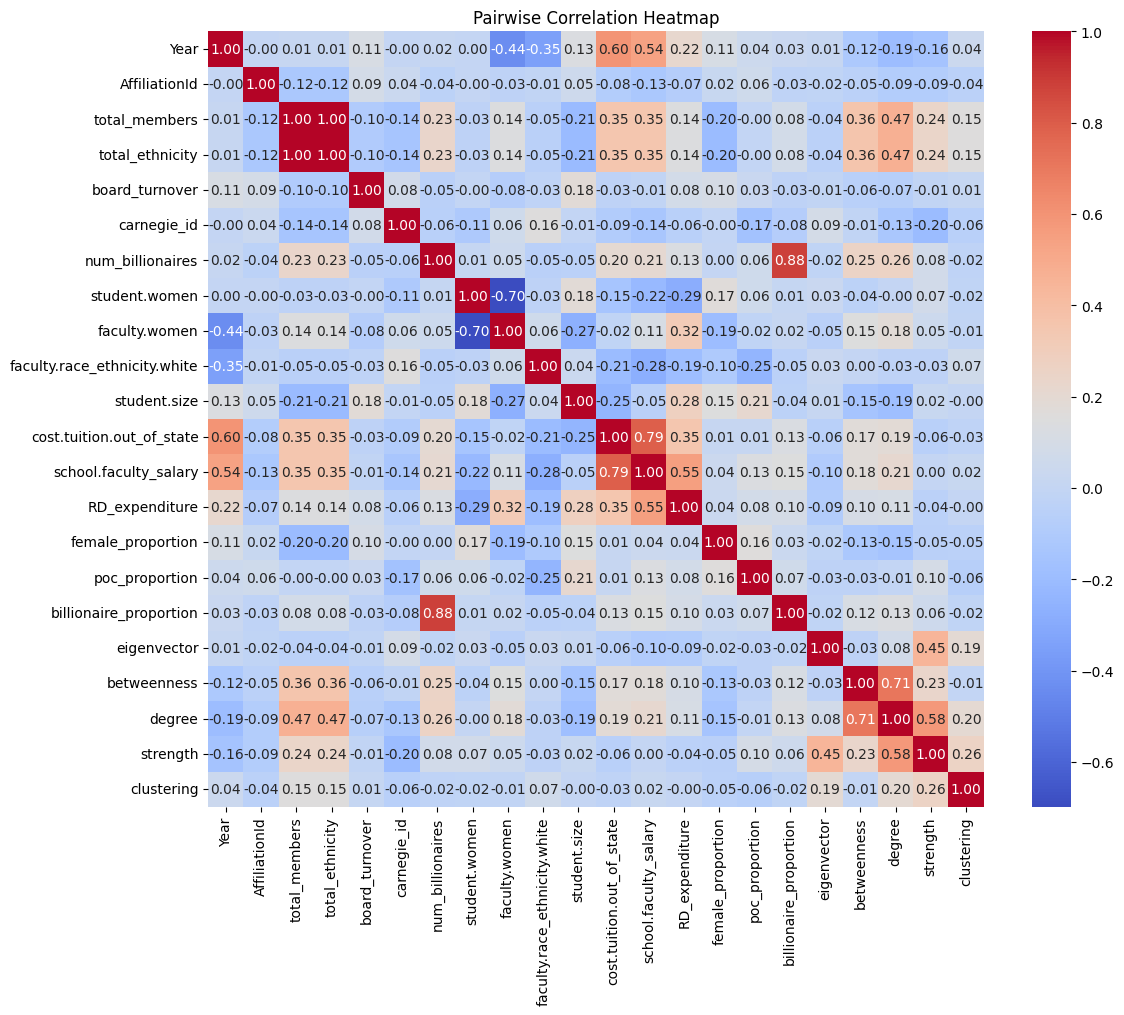

In [27]:
numeric_df = clean_df.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Pairwise Correlation Heatmap")
plt.tight_layout()
plt.show()

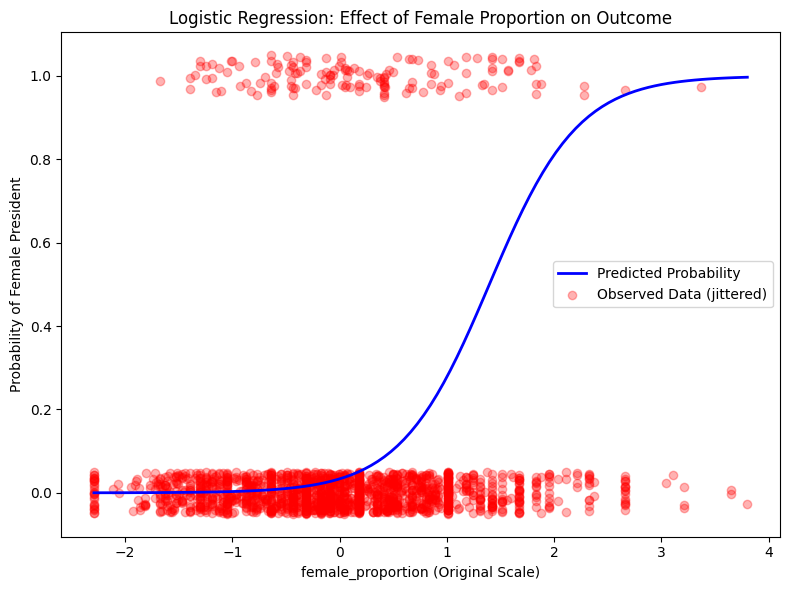

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Choose the variable you want to plot: here "female_proportion"
var_to_plot = "female_proportion"

# Create a range of values for the variable using its original (unscaled) values.
fp_min = regression_data[var_to_plot].min()
fp_max = regression_data[var_to_plot].max()
fp_range = np.linspace(fp_min, fp_max, 100)

# Get the scaling parameters for the variable from the StandardScaler.
if var_to_plot in vars_to_scale:
    idx = vars_to_scale.index(var_to_plot)
    mean_var = scaler.mean_[idx]
    std_var = np.sqrt(scaler.var_[idx])
else:
    raise ValueError(f"{var_to_plot} is not in the list of continuous variables to scale.")

# Transform the original range to the scaled values.
fp_range_scaled = (fp_range - mean_var) / std_var

# Prepare a new DataFrame for predictions.
# Set all predictors at their mean, then override the one we are interested in.
predict_df = pd.DataFrame(columns=X_scaled.columns)
for col in X_scaled.columns:
    predict_df[col] = np.repeat(X_scaled[col].mean(), 100)
predict_df[var_to_plot] = fp_range_scaled

# Get the predicted probabilities from the model.
predict_df["predicted_prob"] = result.predict(predict_df)

# Plot the predicted probability curve.
plt.figure(figsize=(8, 6))
plt.plot(fp_range, predict_df["predicted_prob"], color="blue", lw=2, label="Predicted Probability")

# Add vertical jitter to the observed binary outcomes.
jitter_strength = 0.05  # Adjust the jitter strength as needed
y_jitter = regression_data[dependent_var] + np.random.uniform(-jitter_strength, jitter_strength, len(regression_data))

# Overlay the observed data points with vertical jitter.
plt.scatter(regression_data[var_to_plot], y_jitter, color="red", alpha=0.3, label="Observed Data (jittered)")

plt.xlabel(f"{var_to_plot} (Original Scale)")
plt.ylabel("Probability of Female President")
plt.title("Logistic Regression: Effect of Female Proportion on Outcome")
plt.legend()
plt.tight_layout()
plt.show()


In [29]:

# Filter out rows where the control variable is "Public"
filtered_df = university_board_statistics_df[university_board_statistics_df["control"] != "Public"].copy()

# ----------------------------
# 2. Set Up Regression Variables
# ----------------------------
dependent_var = "female_president"
year_var = "Year"

# New independent variable list WITHOUT "control"
independent_vars = [
    "student.women", 
    "student.size", 
    "female_proportion",
    "billionaire_proportion",
    "total_members",
    # "betweenness",
    # "degree",
    "faculty.race_ethnicity.white",
    "poc_proportion",
    "board_turnover",
    "faculty.women",
    "region",   # will be one-hot encoded
    # "strength",
    "cost.tuition.out_of_state",
    "school.faculty_salary",
    "RD_expenditure"
]

# When dropping missing data, drop on the columns that exist in the original DataFrame.
# (We include "control" in cols_to_check even though we removed it later,
#  to ensure complete rows; adjust if needed.)
cols_to_check = [dependent_var] + independent_vars + [year_var, "region", "control"]

regression_data = filtered_df.dropna(subset=cols_to_check).copy()

# Ensure the dependent variable is binary.
regression_data[dependent_var] = regression_data[dependent_var].astype(int)

# ----------------------------
# 3. One-Hot Encode Categorical Variables
# ----------------------------
# We only one-hot encode Year and region now (skip control).
regression_data = pd.get_dummies(
    regression_data,
    columns=[year_var, "region"],
    drop_first=True
)

# Identify dummy columns for Year and region.
year_dummies = [col for col in regression_data.columns if col.startswith(f"{year_var}_")]
region_dummies = [col for col in regression_data.columns if col.startswith("region_")]

# Build the full predictor list.
# Remove the original "region" from independent_vars (if present) and add our new dummy variables.
predictor_vars = [var for var in independent_vars if var not in ["region", "control"]] \
                 + year_dummies + region_dummies

X = regression_data[predictor_vars]
y = regression_data[dependent_var]

# ----------------------------
# 4. Prepare and Scale the Predictors
# ----------------------------
# Ensure all predictor columns are numeric.
X = X.apply(pd.to_numeric, errors='raise')

# List of continuous variables to be scaled.
continuous_vars = [
    "student.women", 
    "student.size", 
    "female_proportion",
    "billionaire_proportion",
    "total_members",
    # "betweenness",
    # "degree",
    "faculty.race_ethnicity.white",
    "poc_proportion",
    "board_turnover",
    "faculty.women",
    # "strength",
    "cost.tuition.out_of_state",
    "school.faculty_salary",
    "RD_expenditure"
]

scaler = StandardScaler()
vars_to_scale = [var for var in continuous_vars if var in X.columns]
X_scaled = X.copy()
X_scaled[vars_to_scale] = scaler.fit_transform(X_scaled[vars_to_scale])

# Ensure the scaled data is numeric.
X_scaled = X_scaled.apply(pd.to_numeric, errors='raise')

# Add an intercept.
X_scaled = sm.add_constant(X_scaled)
X_scaled = X_scaled.astype(float)

# ----------------------------
# 5. Run the Logistic Regression
# ----------------------------
logit_model = sm.Logit(y, X_scaled)
result = logit_model.fit()

# Create a DataFrame with odds ratios and p-values.
odds_ratios = pd.DataFrame({
    "Variable": X_scaled.columns,
    "Coefficient": result.params,
    "Odds Ratio": np.exp(result.params),
    "P-Value": result.pvalues
})

print(result.summary())
print("\nOdds Ratios and P-Values:")
print(tabulate(odds_ratios, headers="keys", tablefmt="grid"))

# ----------------------------
# 6. Calculate Variance Inflation Factors (VIF)
# ----------------------------
if 'const' in X_scaled.columns:
    X_check = X_scaled.drop('const', axis=1)
else:
    X_check = X_scaled.copy()

vif_data = pd.DataFrame({
    "Variable": X_check.columns,
    "VIF": [variance_inflation_factor(X_check.values, i) for i in range(X_check.shape[1])]
})
print("\nVariance Inflation Factors (VIF):")
print(tabulate(vif_data, headers="keys", tablefmt="grid"))


Optimization terminated successfully.
         Current function value: 0.279855
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:       female_president   No. Observations:                  570
Model:                          Logit   Df Residuals:                      545
Method:                           MLE   Df Model:                           24
Date:                Wed, 19 Feb 2025   Pseudo R-squ.:                  0.2344
Time:                        13:18:33   Log-Likelihood:                -159.52
converged:                       True   LL-Null:                       -208.35
Covariance Type:            nonrobust   LLR p-value:                 7.499e-11
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -4.6782      1.411     -3.317      0.001